In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt         
import sys
import pickle
import librosa
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from sklearn.preprocessing import normalize
import sounddevice as sd
import time


In [6]:
# Choosing one file from our dataset, that we already have as a numpy array.

#a = np.load('/Users/DELL/Updated_binder_enviro/all-samples/cello/cello_A2_1_forte_arco-normal.npy') #numpy array of the audio file
a, Fs=librosa.load('cello_A2_1_forte_arco-normal.mp3',sr=None)       #to load the mp3 file directly                                                        
Fs=44100 #sampling rate of the audio signal
print(a)
print(a.shape)
ipd.Audio(data=a,rate=Fs,autoplay=True) 
duration =librosa.get_duration(y=a, sr=Fs)
print(duration)

[0. 0. 0. ... 0. 0. 0.]
(58752,)
1.3322448979591837


In [22]:
val = next((index for index,value in enumerate(a) if value != 0), None) #finding index of first non zero value occurence in the array
print(val)
print((a!=0).argmax(axis=0))

705
705


In [8]:
infeatures= 1 # samples per input time step
hiddensize= 3 #number of hidden states, the memory elements
outputs=1 #1 samples per output time step
numlayers=1 #number of layers of the network


In [9]:
batch=1 #number of audio signals for training
seq_len=int(Fs*0.5) # Taking the length of sound as just 0.5 seconds (Original length of sound=1.332244 secs)
print(seq_len)

22050


In [10]:
# Device configuration
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
print("device=", device) 

device= cpu


In [11]:
class RNNnet(nn.Module):
    def __init__(self, infeatures, hiddensize, outputs):
      super(RNNnet, self).__init__()
      # Define the model. 
      self.rnn = nn.RNN(input_size=infeatures, hidden_size=hiddensize, num_layers=numlayers, bias=False)
      #forward layer for output
      self.fo = nn.Linear(hiddensize, outputs, bias=False)


    def forward(self, x):
      h_0 = torch.zeros(numlayers, batch, hiddensize).to(device)
      out, hn = self.rnn(x, h_0)
      #Output is simply the hidden state of the last layer (if more than 1 layer)
      out = self.fo(out) #e.g. used to just keep first output
      return out

In [12]:
def signal2pytorch(x):
   #Function to convert a signal vector x, like a mono audio signal, into a 3-d Tensor that Pytorch expects,
   #https://pytorch.org/docs/stable/nn.html
   #Argument x: a 1-d signal as numpy array
   #output: 3-d Pytorch Tensor.
   #for RNN Input: (siglen,batch,features)
   X = np.expand_dims(x, axis=-1)  #add batch  dimension (here only 1 )
   X = np.expand_dims(X, axis=-1)  #add features dimension (here only 1 )
   X=torch.from_numpy(X)
   X=X.type(torch.Tensor)
   return X

22050


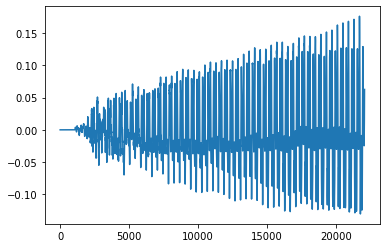

In [23]:
ximp=np.zeros(seq_len) #make impulse with a desired sequence length
ximp[705]=1.0 #impulse at the beginning Ximp input name is same, position of impulse is changed to 705

filtered = a[0:22050] # Shortening the length of the original audio(a) to the length equal to the input ximp = 22050 
                        #and saving it in variable filtered This is also our target, which I changed from the workshop
print(len(filtered))

sd.play(filtered, Fs)


plt.plot(filtered)


In [24]:
inputsig=signal2pytorch(ximp)

print("inputsig.type()=", inputsig.type())
print("inputsig=", inputsig.size)

inputsig.type()= torch.FloatTensor
inputsig= <built-in method size of Tensor object at 0x000002B398820B38>


In [25]:
#Recurrent Neural Network model:
#hidden state update formula:
#ht=tanh(wih xt+bih+whh h(tâˆ’1)+bhh)

#rnn = nn.RNN(input_size=infeatures, hidden_size=hiddensize, num_layers=numlayers, bias=False)

rnn = RNNnet(infeatures, hiddensize, outputs).to(device)

ww = rnn.state_dict()   #read obtained weights
print("weights =", ww)
print("weights shape=", len(ww))

weights = OrderedDict([('rnn.weight_ih_l0', tensor([[ 0.0634],
        [-0.2729],
        [ 0.0517]])), ('rnn.weight_hh_l0', tensor([[ 0.4642, -0.1830, -0.5528],
        [-0.4948, -0.0592, -0.4524],
        [ 0.1281, -0.4890,  0.5089]])), ('fo.weight', tensor([[-0.1775, -0.0063, -0.0801]]))])
weights shape= 3


In [26]:
target= signal2pytorch(filtered)
print("target.type()=", target.type())
print("target=", target)

target.type()= torch.FloatTensor
target= tensor([[[0.0000]],

        [[0.0000]],

        [[0.0000]],

        ...,

        [[0.0549]],

        [[0.0591]],

        [[0.0627]]])


In [27]:
#random starting point as initialization:
#rnn.state_dict()['rnn.weight_hh_l0'].data.copy_(torch.randn(hiddensize,hiddensize))

rnn.state_dict()['rnn.weight_hh_l0'].data.copy_(torch.zeros(hiddensize,hiddensize))

#rnn.state_dict()['rnn.weight_ih_l0'].data.copy_(torch.randn((hiddensize,1)))
rnn.state_dict()['rnn.weight_ih_l0'].data.copy_(torch.zeros((hiddensize,1)))

#rnn.state_dict()['fo.weight'][0,:].data.copy_(torch.tensor([ 1.0, 0.0 ,0.0]))

#rnn.state_dict()['fo.weight'][0,:].data.copy_(torch.zeros(hiddensize))
rnn.state_dict()['fo.weight'][0,:].data.copy_(torch.randn(hiddensize))

tensor([ 1.0045, -0.2802, -0.3004])

In [30]:
#rnn.__init__(infeatures, hiddensize)
rnn = RNNnet(infeatures, hiddensize, outputs).to(device)

ww = rnn.state_dict()   #read current weights
print("weights =", ww)
print('Total number of parameters: %i' % (sum(p.numel() for p in rnn.parameters() if p.requires_grad)))

weights = OrderedDict([('rnn.weight_ih_l0', tensor([[ 0.4788],
        [ 0.3719],
        [-0.3092]])), ('rnn.weight_hh_l0', tensor([[ 0.4600,  0.3190,  0.4101],
        [-0.3642, -0.4438,  0.1306],
        [-0.0409, -0.2157,  0.3733]])), ('fo.weight', tensor([[0.3911, 0.2798, 0.5666]]))])
Total number of parameters: 15


In [31]:
loss_fn = nn.MSELoss(size_average=False)
#learning_rate = 1e-3
optimizer = torch.optim.Adam(rnn.parameters())#, lr=learning_rate)

Ypred=rnn(inputsig)
print("starting loss:", loss_fn(Ypred, target).item())
#print("Start optimization") 
print("Starting training the neural network")
os.system('espeak -s 120 "Starting training the neural network"')

starting loss: 69.1661605834961
Starting training the neural network


1

In [32]:
randdir=False #True for optimization of random directions
#--Start optimization of random directions------------------------
if randdir == True:
   #optimization of weights using method of random directions:
   starttime=time.time()

   optimrandomdir_pytorch.optimizer(rnn, loss_fn, inputsig, target, iterations=1500, startingscale=0.1, endscale=0.0)

   endtime=time.time()
   print("Duration of optimization:", endtime-starttime)
   #--End optimization of random directions------------------------

else:
   starttime=time.time()
   for epoch in range(500):
       Ypred=rnn(inputsig)
       loss=loss_fn(Ypred, target)
       if epoch%10==0:
          print(epoch, loss.item())
       optimizer.zero_grad()
       loss.backward()
       optimizer.step()
   endtime=time.time()

0 69.1661605834961
10 69.15945434570312
20 69.15392303466797
30 69.14950561523438
40 69.14608001708984
50 69.14344787597656
60 69.14144897460938
70 69.13993835449219
80 69.13880157470703
90 69.13795471191406
100 69.13732147216797
110 69.1368637084961
120 69.13652801513672
130 69.13628387451172
140 69.13610076904297
150 69.13597106933594
160 69.13587951660156
170 69.13580322265625
180 69.1357421875
190 69.13569641113281
200 69.13565826416016
210 69.13562774658203
220 69.13560485839844
230 69.13558197021484
240 69.13555908203125
250 69.13554382324219
260 69.13552856445312
270 69.1355209350586
280 69.13551330566406
290 69.13550567626953
300 69.135498046875
310 69.13549041748047
320 69.13549041748047
330 69.13548278808594
340 69.13548278808594
350 69.1354751586914
360 69.1354751586914
370 69.1354751586914
380 69.1354751586914
390 69.1354751586914
400 69.1354751586914
410 69.13546752929688
420 69.13546752929688
430 69.13546752929688
440 69.13546752929688
450 69.13546752929688
460 69.1354675

[[[0.]]

 [[0.]]

 [[0.]]

 ...

 [[0.]]

 [[0.]]

 [[0.]]]
[0. 0. 0. ... 0. 0. 0.]


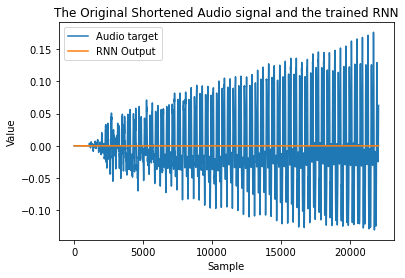

weights = OrderedDict([('rnn.weight_ih_l0', tensor([[ 0.4148],
        [ 0.2894],
        [-0.3434]])), ('rnn.weight_hh_l0', tensor([[ 0.5411,  0.4576,  0.3193],
        [-0.2711, -0.3070,  0.0295],
        [ 0.0463, -0.0703,  0.2774]])), ('fo.weight', tensor([[0.4018, 0.1754, 0.6264]]))])


In [34]:
outsig= rnn(inputsig)
outsig=outsig.detach()
outsig=np.array(outsig) #turn into numpy array
print(outsig)
outsig=outsig[:,0,0]
print(outsig)

plt.plot(filtered)
plt.plot(outsig)
plt.legend(('Audio target','RNN Output'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title("The Original Shortened Audio signal and the trained RNN")
plt.show()

os.system('espeak -s 120 "The impulse response sound from the trained recurrent neural network"')
sd.play(outsig, Fs)

ww = rnn.state_dict()   #read obtained weights
print("weights =", ww)
